In [46]:
import pyarrow
import fastparquet
import pandas as pd

## Exploratory Analysis - Data Preview 

In [47]:
#Data Download and Preview 
df = pd.read_parquet('/Users/camryncurtis/Documents/GitHub/Capstone-Project/data/raw/prepros_summer_lax_snappy.parquet')
print(df.head())


                              legId  searchDate  flightDate startingAirport  \
0  006987aea766442f625ccd84bde23ff3  2022-04-17  2022-06-01             LAX   
1  2181b0ab7161f081228a0c600d756eaf  2022-04-17  2022-06-01             LAX   
2  1ad5b31e3269695b008e5001f06d627a  2022-04-17  2022-06-01             LAX   
3  8e3f3570d010c80500d98f66bfc49777  2022-04-17  2022-06-01             LAX   
4  7ff208a7f5d75b1a97d54b983eb4fabf  2022-04-17  2022-06-01             LAX   

  destinationAirport fareBasisCode travelDuration  isBasicEconomy  \
0                ATL         GA7NR       PT14H25M           False   
1                ATL         GA7NR       PT10H42M           False   
2                ATL         UA7NR        PT9H49M           False   
3                ATL        U0XSNR       PT12H42M           False   
4                ATL       M03PXP5        PT6H17M           False   

   isRefundable  isNonStop  ...  seatsRemaining  totalTravelDistance  \
0         False      False  ...       

In [48]:
#Datatype and Summary Statistics
print(df.info())
print(df.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4329731 entries, 0 to 4329730
Data columns (total 22 columns):
 #   Column                             Dtype  
---  ------                             -----  
 0   legId                              object 
 1   searchDate                         object 
 2   flightDate                         object 
 3   startingAirport                    object 
 4   destinationAirport                 object 
 5   fareBasisCode                      object 
 6   travelDuration                     object 
 7   isBasicEconomy                     bool   
 8   isRefundable                       bool   
 9   isNonStop                          bool   
 10  baseFare                           float64
 11  totalFare                          float64
 12  seatsRemaining                     int64  
 13  totalTravelDistance                float64
 14  segmentsDepartureTimeEpochSeconds  object 
 15  segmentsArrivalTimeEpochSeconds    object 
 16  segmentsArrivalAir

In [49]:
# Check for missing values
missing_values = df.isnull().sum()
print(missing_values)


legId                                     0
searchDate                                0
flightDate                                0
startingAirport                           0
destinationAirport                        0
fareBasisCode                             0
travelDuration                            0
isBasicEconomy                            0
isRefundable                              0
isNonStop                                 0
baseFare                                  0
totalFare                                 0
seatsRemaining                            0
totalTravelDistance                  456372
segmentsDepartureTimeEpochSeconds         0
segmentsArrivalTimeEpochSeconds           0
segmentsArrivalAirportCode                0
segmentsDepartureAirportCode              0
segmentsAirlineName                       0
segmentsDurationInSeconds                 0
segmentsDistance                          0
segmentsCabinCode                         0
dtype: int64


In [50]:
#Drop totalTravelDistance and segmentsDistance due to missing values

df.drop(columns=['segmentsDistance', 'totalTravelDistance'], inplace=True)


## Exploratory Analysis - Visualizations 

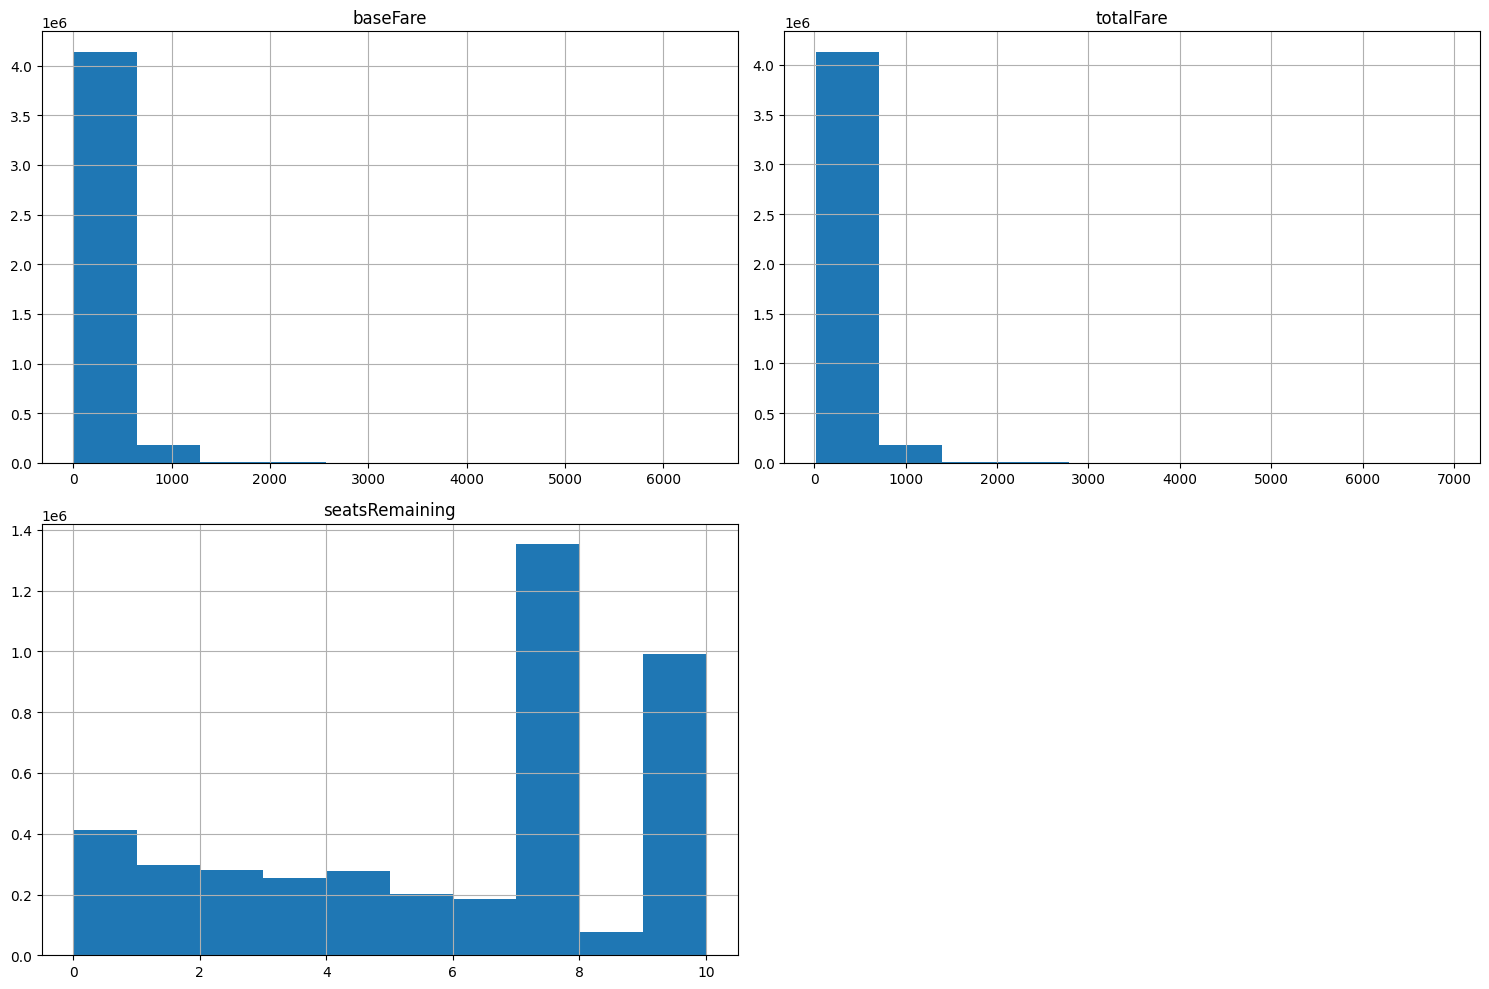

In [51]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot histograms for numerical columns
df.hist(figsize=(15, 10))
plt.tight_layout()
plt.show()


## Feature Engineering 

In [52]:
df['num_segments'] = df['segmentsDepartureTimeEpochSeconds'].str.count(r'\|\|') + 1
max_segments = df['num_segments'].max()

print(f"Maximum number of segments in any row: {max_segments}")


Maximum number of segments in any row: 4


In [53]:
# Split departure and arrivals into separate columns
df[['dep_1', 'dep_2', 'dep_3', 'dep_4']] = df['segmentsDepartureTimeEpochSeconds'].str.split(r'\|\|', expand=True)
df[['arr_1', 'arr_2', 'arr_3', 'arr_4']] = df['segmentsArrivalTimeEpochSeconds'].str.split(r'\|\|', expand=True)

# Convert epoch times to datetime
for col in ['dep_1', 'dep_2', 'dep_3', 'dep_4', 'arr_1', 'arr_2', 'arr_3', 'arr_4']:
    df[col] = pd.to_datetime(df[col].astype(float), unit='s', errors='coerce')

# Recalculate num_segments based on non-NA values for departure times
df['num_segments'] = df[['dep_1', 'dep_2', 'dep_3', 'dep_4']].notna().sum(axis=1)

In [55]:
# Calculate layover times for each segment
def calculate_layover(dep_col, arr_col, next_dep_col):
    if pd.notna(dep_col) and pd.notna(arr_col):
        return (next_dep_col - arr_col).total_seconds() / 3600 if pd.notna(next_dep_col) else 0
    return 0

# Calculate layover times for each segment
df['layover_1'] = df.apply(lambda row: calculate_layover(row['dep_1'], row['arr_1'], row['dep_2']), axis=1)
df['layover_2'] = df.apply(lambda row: calculate_layover(row['dep_2'], row['arr_2'], row['dep_3']), axis=1)
df['layover_3'] = df.apply(lambda row: calculate_layover(row['dep_3'], row['arr_3'], row['dep_4']), axis=1)

# Sum layover times, handling NaNs
df['total_layover_time'] = df[['layover_1', 'layover_2', 'layover_3']].sum(axis=1, skipna=True)

# Correct max layover calculation to reflect the maximum individual layover time
df['max_layover'] = df[['layover_1', 'layover_2', 'layover_3']].max(axis=1, skipna=True)

# Calculate average layover, only considering the valid layovers for each flight
def calculate_avg_layover(row):
    """Calculate the average layover time, only considering non-zero layovers."""
    layovers = [row['layover_1'], row['layover_2'], row['layover_3']]
    
    # Filter out the zero or NaN layovers
    valid_layovers = [layover for layover in layovers if pd.notna(layover) and layover > 0]
    
    # Calculate the average of the valid layovers
    if valid_layovers:  # If there are any valid layovers
        return sum(valid_layovers) / len(valid_layovers)
    else:
        return 0  # Return 0 if no valid layovers

# Apply the function to calculate average layover
df['avg_layover'] = df.apply(calculate_avg_layover, axis=1)


In [56]:
# Calculate the total flight duration, excluding layovers
def calculate_flight_duration(row):
    total_duration = 0
    num_segments = row['num_segments']
    
    # Ensure there are valid departure and arrival times to compute the duration
    if num_segments >= 1 and pd.notna(row['dep_1']) and pd.notna(row[f'arr_{num_segments}']):
        # Total time between first departure and last arrival
        total_duration = (row[f'arr_{num_segments}'] - row['dep_1']).total_seconds() / 3600
    
    # Subtract layover times to get only time spent flying
    total_duration -= row['total_layover_time']
    
    return total_duration

# Apply the function to calculate total flight duration
df['total_flight_duration'] = df.apply(calculate_flight_duration, axis=1)

In [57]:
# Calculate segment durations for each leg
def calculate_segment_duration(dep_col, arr_col):
    """Calculate the duration of a segment between departure and arrival times."""
    if pd.notna(dep_col) and pd.notna(arr_col):
        return (arr_col - dep_col).total_seconds() / 3600  # Duration in hours
    return 0

# Apply the function to calculate segment durations for each leg
df['segment_1_duration'] = df.apply(lambda row: calculate_segment_duration(row['dep_1'], row['arr_1']), axis=1)
df['segment_2_duration'] = df.apply(lambda row: calculate_segment_duration(row['dep_2'], row['arr_2']), axis=1)
df['segment_3_duration'] = df.apply(lambda row: calculate_segment_duration(row['dep_3'], row['arr_3']), axis=1)
df['segment_4_duration'] = df.apply(lambda row: calculate_segment_duration(row['dep_4'], row['arr_4']), axis=1)

# Update max_segment_duration by finding the maximum duration of the available segments
df['max_segment_duration'] = df[['segment_1_duration', 'segment_2_duration', 'segment_3_duration', 'segment_4_duration']].max(axis=1, skipna=True)

# Calculate minimum segment duration (excluding zero durations)
def calculate_min_segment_duration(row):
    """Calculate minimum segment duration excluding zero values."""
    segment_durations = [
        row['segment_1_duration'],
        row['segment_2_duration'],
        row['segment_3_duration'],
        row['segment_4_duration']
    ]
    
    # Filter out zero durations and find the minimum
    non_zero_durations = [duration for duration in segment_durations if duration > 0]
    
    if non_zero_durations:  # Check if there are non-zero durations
        return min(non_zero_durations)
    else:
        return 0  # Return 0 if no valid segment durations are found

# Apply the function to calculate the minimum segment duration
df['min_segment_duration'] = df.apply(calculate_min_segment_duration, axis=1)



In [60]:
# Output the corrected summary columns
print(df[['total_flight_duration', 'total_layover_time', 'num_segments', 'max_segment_duration','min_segment_duration', 'max_layover' , 'avg_layover']].head())


   total_flight_duration  total_layover_time  num_segments  \
0                   5.25            9.166667             2   
1                   6.90            3.800000             2   
2                   6.05            3.766667             2   
3                   5.25            7.450000             2   
4                   5.00            1.283333             2   

   max_segment_duration  min_segment_duration  max_layover  avg_layover  
0              4.000000              1.250000     9.166667     9.166667  
1              5.000000              1.900000     3.800000     3.800000  
2              4.066667              1.983333     3.766667     3.766667  
3              4.000000              1.250000     7.450000     7.450000  
4              3.916667              1.083333     1.283333     1.283333  
